In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
#convolutional model
class ConvModel(nn.Module):
    def __init__(self, output_features=1, input_channels=1, conv_out_channels=16, kernel_size=3, input_size=28):
        super(ConvModel, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv1d(input_channels, conv_out_channels, kernel_size=kernel_size)
        # Calculate the size after convolution (simplified calculation assuming stride=1 and padding=0)
        conv_output_size = input_size - kernel_size + 1
        # Fully connected layer after flattening the conv output
        self.fc1 = nn.Linear(conv_out_channels * (conv_output_size ** 2), output_features)

    def forward(self, x):
        # Apply convolution
        x = F.relu(self.conv1(x))
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        # Output layer
        x = self.fc1(x)
        return x

In [ ]:
#pure linear model
class LinearModel(nn.Module):
    def __init__(self, output_features=1, input_features=2, l1=9, l2=10, l3=15, l4=12):
        super(LinearModel, self).__init__()

        self.fc1 = nn.Linear(input_features, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.fc4 = nn.Linear(l3, l4)

        self.out1 = nn.Linear(l4, output_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = self.out1(x)
        return x

In [ ]:
#Load data
githuburl = "https://github.com/nikojlieto/antennann/raw/main/data/5tags-circle-antennasweep%20(calculations%20included).csv"
my_df = pd.read_csv(githuburl)

In [ ]:
list(my_df.columns)

In [ ]:
#Data preparation
input_columns = ['phase (radians)', 'prx deoscillated moving parts ()', 'doppler ()']
X = my_df[input_columns].values
output_columns = ['New R from Prx']
y = my_df[output_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [ ]:
#Model instantiation
model_type = "Linear"
if model_type == "Linear":
    model = LinearModel(output_features=1, input_features=len(input_columns))
if model_type == "Conv":
    model = ConvModel(output_features=1, input_channels=len(input_columns))
criterion = nn.MSELoss()  # Changed to MSE for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#Training loop
epochs = 2000
losses = []
for i in range(epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    if i % 100 == 0:
        #print(y_pred)
        print(f'Epoch: {i}\t and loss: {loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch: 0 and loss: 44390776832.0
Epoch: 100 and loss: 1672294016.0
Epoch: 200 and loss: 190215184.0
Epoch: 300 and loss: 77932824.0
Epoch: 400 and loss: 43809384.0
Epoch: 500 and loss: 34707988.0
Epoch: 600 and loss: 32426776.0
Epoch: 700 and loss: 31668540.0
Epoch: 800 and loss: 31312502.0
Epoch: 900 and loss: 31098158.0
Epoch: 1000 and loss: 30960762.0
Epoch: 1100 and loss: 30871644.0
Epoch: 1200 and loss: 30811724.0
Epoch: 1300 and loss: 30770486.0
Epoch: 1400 and loss: 30740476.0
Epoch: 1500 and loss: 30717692.0
Epoch: 1600 and loss: 30701416.0
Epoch: 1700 and loss: 30688600.0
Epoch: 1800 and loss: 30678976.0
Epoch: 1900 and loss: 30671842.0


Linear
Test Loss: 31065462.0

threshold = 4 %
ratio within thresh = 0.9079468325791855
highest percent error = 6.813543973254436
avg error = 4045.4534502262445
avg percent error = 2.02088739724462


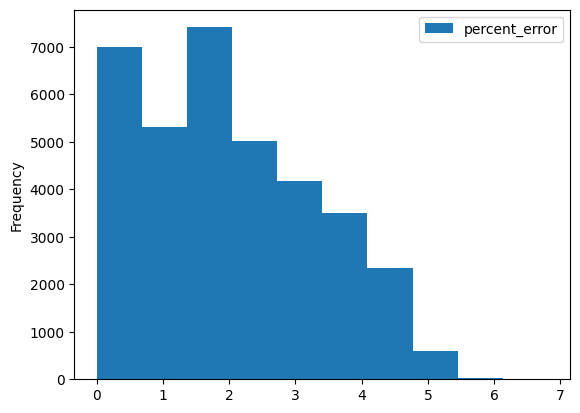

In [ ]:
#Model evaluation
print(model_type)
thresh = 4 #percentage threshold of allowed error to check beyond
count = 0
cum_diff = 0
cum_diff_percent = 0
errors_percent = []
max_percent_error = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_eval = model(X_test)
    loss = criterion(y_eval, y_test)
    print(f'Test Loss: {loss.item()}\n')

    for i in range(len(y_eval)):
      #print("eval", y_eval[i], "\n test", y_test[i], "\n difference", y_eval[i] - y_test[i])
      diff = (int(y_eval[i]) - int(y_test[i]))
      if (diff < 0):
          diff = -diff
      percent_diff = 100 * (diff / int(y_test[i]))
      cum_diff += diff
      cum_diff_percent += percent_diff
      errors_percent.append(percent_diff)
      if(percent_diff > thresh):
          #print("eval", y_eval[i], "\n test", y_test[i], "\n difference", y_eval[i] - y_test[i])
          count = count + 1
      if(percent_diff > max_percent_error):
         max_percent_error = percent_diff
    print("threshold =", thresh, "%")
    #print("count beyond thresh =", count, "ratio =", count/len(y_eval))
    print("ratio within thresh =", 1 - count/len(y_eval))
    print("highest percent error =", max_percent_error)
    print("avg error =", cum_diff / len(y_eval))
    print("avg percent error =", cum_diff_percent / len(y_eval))
    df_eval = pd.DataFrame({"percent_error": errors_percent})
    ax = df_eval.plot.hist()

In [ ]:
#Save the trained model
torch.save(model.state_dict(), 'trained_model.pt')